## Libraries

In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
from IPython.display import HTML
from rdkit import Chem
from rdkit.Chem import PandasTools, Descriptors
import matplotlib.pyplot as plt
import missingno as msno
%matplotlib inline
# from rdkit.Chem.MolStandardize.rdMolStandardize import StandardizeSmiles
# import session_info

In [2]:
# Defining a function to print all structures in mol correctly
def show_df(df):
    return HTML(df.to_html(notebook=True))

## Basic summary statistics

In this initial section, we will conduct a preliminary examination of our dataset to gain essential insights and identify any potential issues it might contain.

### Importing the dataset

In [3]:
# Reading the csv file
fda_drugs = pd.read_csv('../../data/pre_cleaned_datasets/pre_cleaned_unique.csv')
# Basic dataframe strucutre
print("This is the basic shape that our dataset has (NxM) with N being the number of rows and M the number of columns:\n", fda_drugs.shape)

This is the basic shape that our dataset has (NxM) with N being the number of rows and M the number of columns:
 (1908, 14)


First of all, the molecules structures are in SMILES format, as it is compatible with any csv file. Nonetheless, this chemical structure format is known for being redundant, i.e., multiple SMILES can represent the same 2D structure. In order to avoid that, we performed its conversion to a standard SMILES format, known as `canonical SMILES` and stored in the `clean_smiles` variable. More in-depth information about the redundancy of SMILES can be read in the [OpenBabel documentation](https://openbabel.org/docs/current/FileFormats/Canonical_SMILES_format.html) or even in the [RDKit docs](https://www.rdkit.org/docs/GettingStartedInPython.html), with some examples.

The dataframe is comprised of the following variables, with each column indicating one information about the drug:

In [4]:
fda_drugs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1908 entries, 0 to 1907
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   name                  1908 non-null   object
 1   chembl_id             1908 non-null   object
 2   clean_smiles          1908 non-null   object
 3   first_approval_year   1908 non-null   object
 4   indication_class      1456 non-null   object
 5   molecule_type         1908 non-null   object
 6   withdrawn_flag        1908 non-null   bool  
 7   therapeutic_flag      1908 non-null   bool  
 8   polymer_flag          1908 non-null   bool  
 9   inorganic_flag        1908 non-null   bool  
 10  natural_product_flag  1908 non-null   bool  
 11  oral                  1908 non-null   bool  
 12  parenteral            1908 non-null   bool  
 13  topical               1908 non-null   bool  
dtypes: bool(8), object(6)
memory usage: 104.5+ KB


One can note that the majority of information is of type `bool` and are related to the dosage form/route of administration. The variables `indication_class` and `first_appoval_year` are missing some of the data. The reason why `first_approval_year` appears to have 0 null values is because we identified the years missing as 'not found', and a string is not a null value. We need to transform every entry of `first_approval_year` that is 'not found' to a simple NaN or null-value.


In [5]:
print(f"We have {fda_drugs.loc[fda_drugs.first_approval_year == 'not found', 'first_approval_year'].count()} structures with missing year of approval\n")
fda_drugs['first_approval_year'] =fda_drugs.first_approval_year.replace('not found', np.nan)
print("After changing the value of 'not found' with proper NaN values\n")
fda_drugs.info()

We have 285 structures with missing year of approval

After changing the value of 'not found' with proper NaN values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1908 entries, 0 to 1907
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   name                  1908 non-null   object
 1   chembl_id             1908 non-null   object
 2   clean_smiles          1908 non-null   object
 3   first_approval_year   1623 non-null   object
 4   indication_class      1456 non-null   object
 5   molecule_type         1908 non-null   object
 6   withdrawn_flag        1908 non-null   bool  
 7   therapeutic_flag      1908 non-null   bool  
 8   polymer_flag          1908 non-null   bool  
 9   inorganic_flag        1908 non-null   bool  
 10  natural_product_flag  1908 non-null   bool  
 11  oral                  1908 non-null   bool  
 12  parenteral            1908 non-null   bool  
 13  topical             

### Missing data

We can now explore some basic info about the data. We are going to visualize possible missing information using the `missingno` package. 

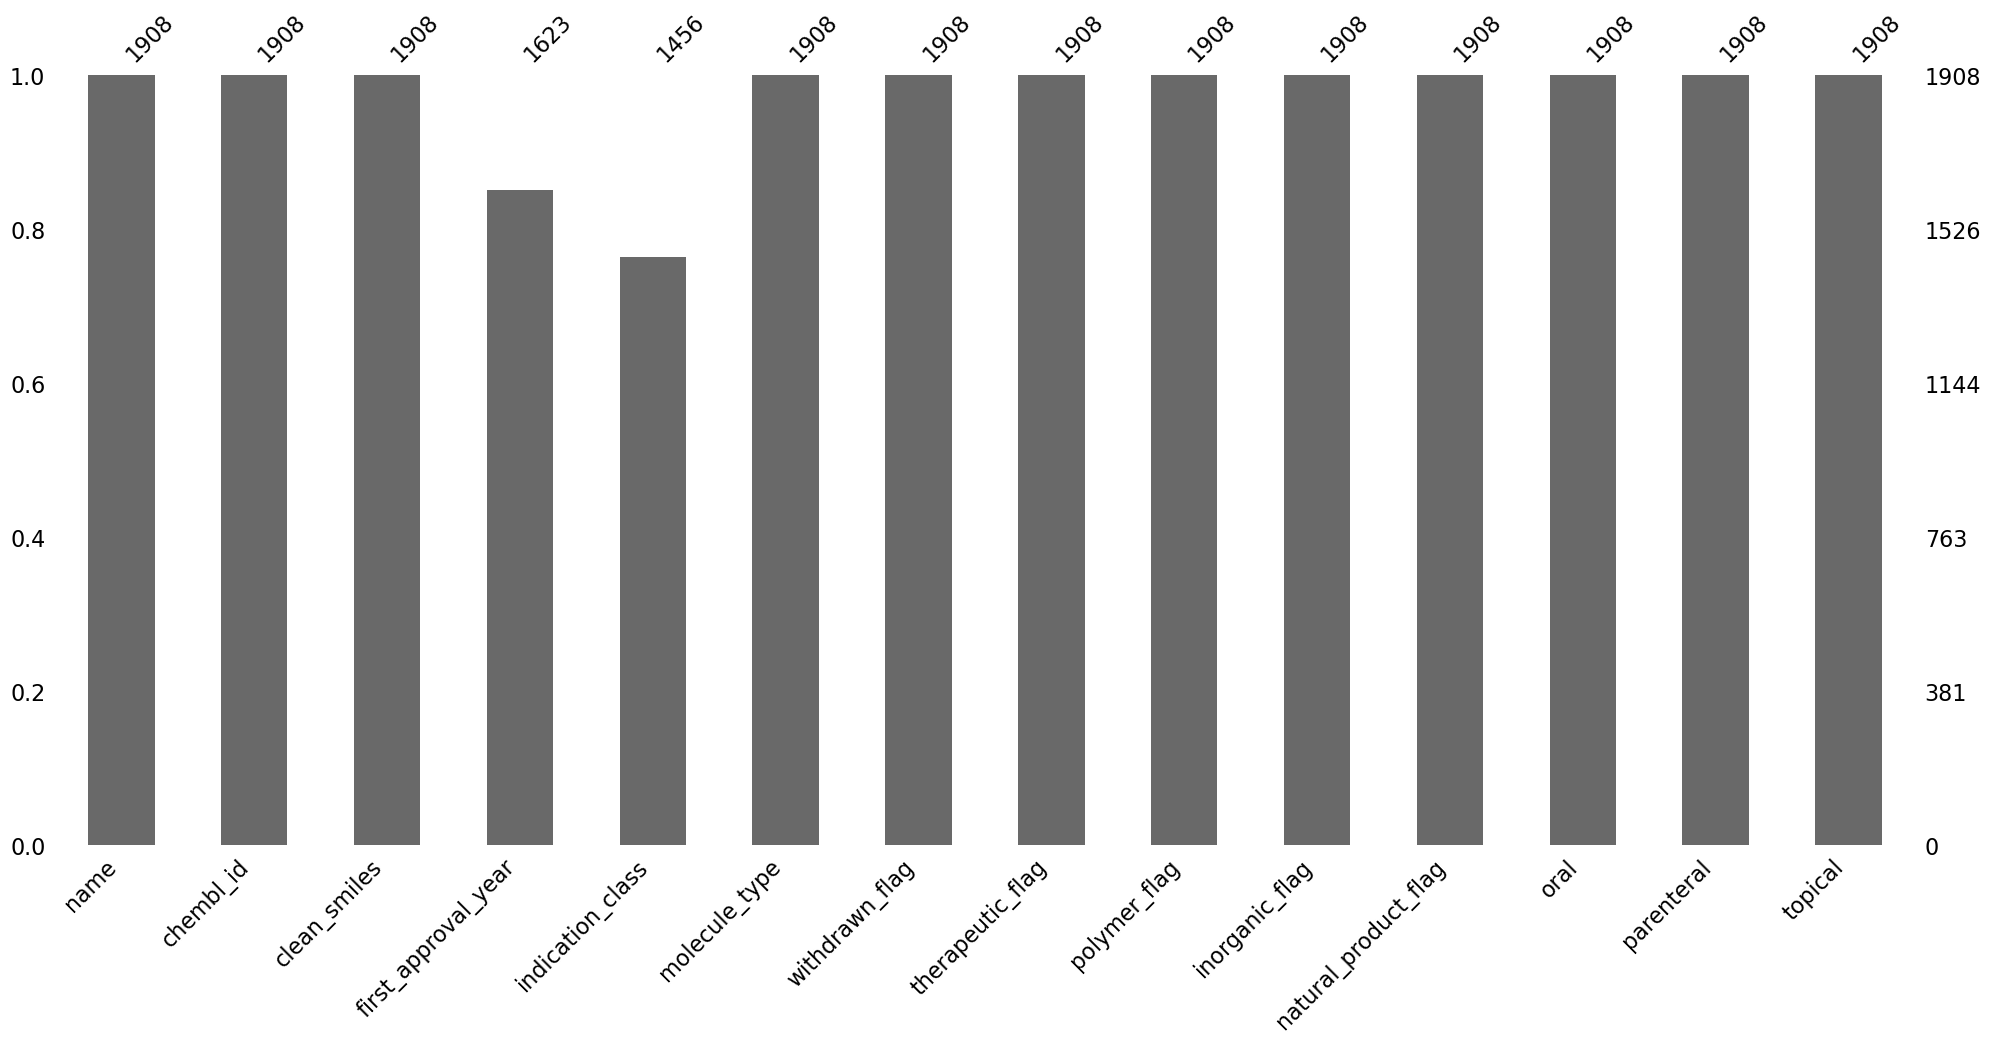

In [6]:
g = msno.bar(fda_drugs)

Another way to visualize is to use a seaborn heatmap of the missing data:

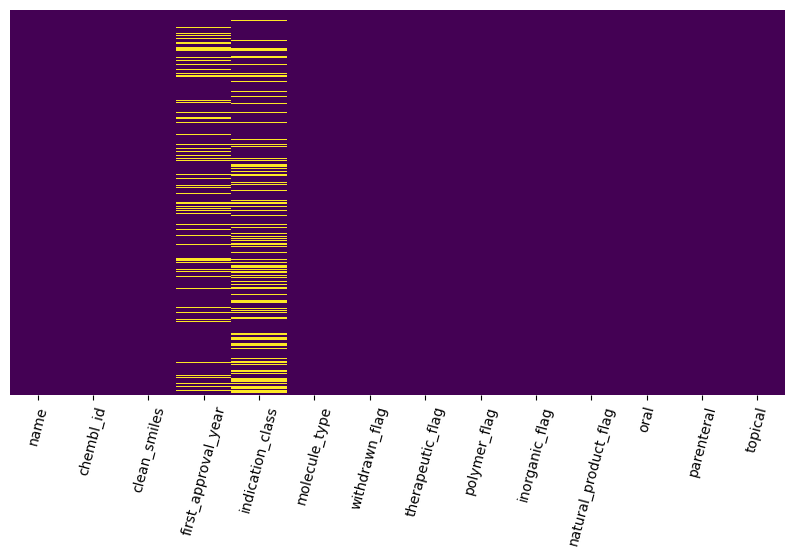

In [26]:
fig, ax = plt.subplots(figsize=(10,5))
g = sns.heatmap(fda_drugs.isnull(), yticklabels=False, cbar=False, cmap='viridis', ax=ax)
labels = g.get_xticklabels()
ax.set_xticklabels(labels=labels,rotation=75)
plt.show()

The bars indicate how much data is complete for each variable, the higher it is, less data is missing. Only `indication_class` and `first approval year` have NA missing, but ~80% of the data is present for these variables.

Another thing to note is that we have A LOT of different indication classes. For instance we have: 

In [14]:
fda_drugs.indication_class.unique().shape

(1031,)

More than ONE THOUSAND diferent indication classes. As suggested by @Artur, we could use ChatGPT to standardize the labels for it, but we'll leave it that way for now. 

### Basic summary WIP

In [47]:
fda_drugs.describe()

,name,chembl_id,clean_smiles,first_approval_year,indication_class,molecule_type,withdrawn_flag,therapeutic_flag,polymer_flag,inorganic_flag,natural_product_flag,oral,parenteral,topical
count,1908,1908,1908,1623,1456,1908,1908,1908,1908,1908,1908,1908,1908,1908
unique,1906,1908,1908,127,1030,1,2,1,1,1,2,2,2,2
top,DEUCRAVACITINIB,CHEMBL1200728,N=C(N)N,1982,Antibacterial,Small molecule,False,True,False,False,False,True,False,False
freq,2,1,1,100,62,1908,1790,1908,1908,1908,1384,1185,1400,1562


In [55]:
print(fda_drugs.query("name == 'DEUCRAVACITINIB'")['clean_smiles'].values) # Isso ok
fda_drugs.query("name == 'MERCAPTOPURINE'")['clean_smiles'].values # Isso é tautômero, melhor resolver

['CNC(=O)c1nnc(NC(=O)C2CC2)cc1Nc1cccc(-c2ncn(C)n2)c1OC'
 '[2H]C([2H])([2H])NC(=O)c1nnc(NC(=O)C2CC2)cc1Nc1cccc(-c2ncn(C)n2)c1OC']


array(['Sc1ncnc2nc[nH]c12', 'S=c1[nH]cnc2nc[nH]c12'], dtype=object)

from plotnine import *

(ggplot(tips, aes('day', 'tip', fill='sex'))
 + geom_bar(stat='identity', position='stack')
 + ggtitle('Tips by Day and Gender')
)
